In [121]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score, f1_score, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

In [65]:
features = pd.read_csv("C:/Users/viczh/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_features.csv", header=None)
classes = pd.read_csv("C:/Users/viczh/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
edges = pd.read_csv("C:/Users/viczh/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")

In [67]:
# first column: txId
# second column: timestep
# remaining 165 columns: features
colnames = ["txId", "timestep"] + [f"f_{i}" for i in range(165)]
features.columns = colnames

In [69]:
# Merge label information
df = features.merge(classes, on="txId", how="left")

In [71]:
df = df[df["class"] != "unknown"]   # keep only labeled data
df = df.drop(columns=["txId"])

In [73]:
# Map labels: 2 = licit (0), 1 = illicit (1)
label_map = {"1": 1, "2": 0}
df["class"] = df["class"].map(label_map)

In [75]:
df["class"].unique()

array([0, 1])

In [77]:
df.head()

,timestep,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,...,f_156,f_157,f_158,f_159,f_160,f_161,f_162,f_163,f_164,class
3,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,...,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,0
9,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,-0.144554,...,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792,0
10,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,-0.144108,...,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0
11,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.141519,-0.147643,...,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0
16,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,-0.163640,-0.169115,...,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984,0


In [79]:
# Train-test split
X = df.drop(columns=["class"])
y = df["class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

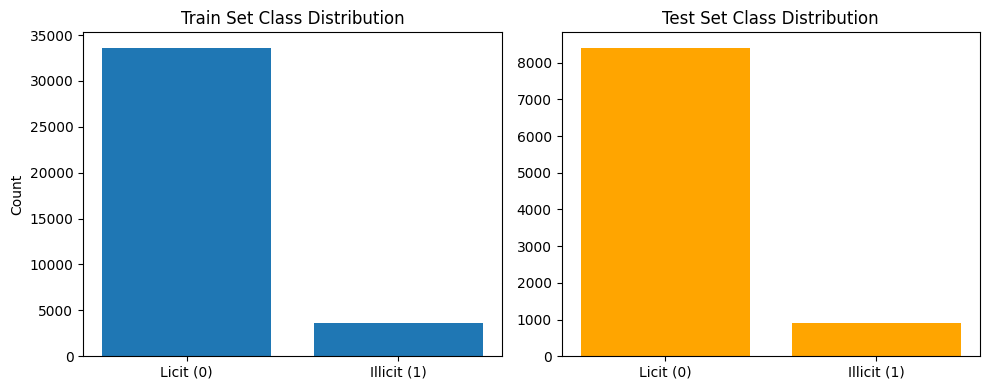

In [93]:
# Plot class distribution
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

train_counts = y_train.value_counts().sort_index()
test_counts = y_test.value_counts().sort_index()
labels = ["Licit (0)", "Illicit (1)"]

# Train distribution
ax[0].bar(labels, train_counts.values)
ax[0].set_title("Train Set Class Distribution")
ax[0].set_ylabel("Count")

# Test distribution
ax[1].bar(labels, test_counts.values, color="orange")
ax[1].set_title("Test Set Class Distribution")

plt.tight_layout()
plt.show()

In [87]:
# RANDOM FOREST MODEL
model = RandomForestClassifier(
    n_estimators=225,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)

model.fit(X_train, y_train)

,n_estimators,225
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [105]:
#  Classification report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8404
           1       1.00      0.88      0.93       909

    accuracy                           0.99      9313
   macro avg       0.99      0.94      0.96      9313
weighted avg       0.99      0.99      0.99      9313



<Figure size 500x400 with 0 Axes>

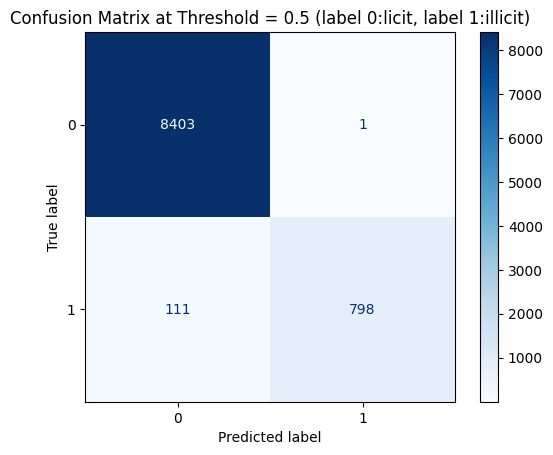

In [129]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='d')
plt.title(f"Confusion Matrix at Threshold = 0.5 (label 0:licit, label 1:illicit)")
plt.show()

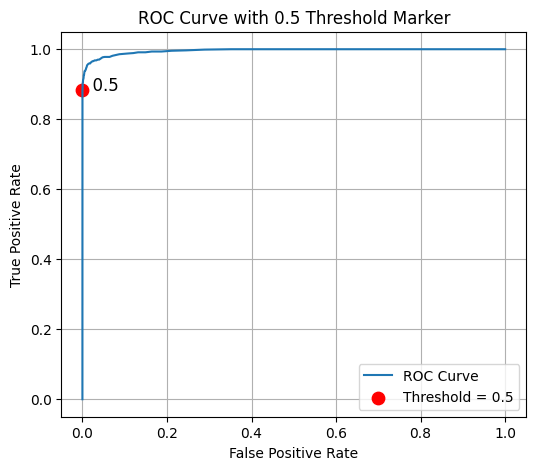

In [133]:
# Compute ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_prob)

# Compute the point corresponding to threshold = 0.5
# roc_thresholds aligns with fpr/tpr except the last element
# So we find the closest threshold to 0.5
idx_05 = np.argmin(np.abs(roc_thresholds - 0.5))

fpr_05 = fpr[idx_05]
tpr_05 = tpr[idx_05]

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label="ROC Curve")
plt.scatter(fpr_05, tpr_05, color="red", s=80, label="Threshold = 0.5")
plt.text(fpr_05, tpr_05, "  0.5", fontsize=12)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with 0.5 Threshold Marker")
plt.legend()
plt.grid(True)
plt.show()

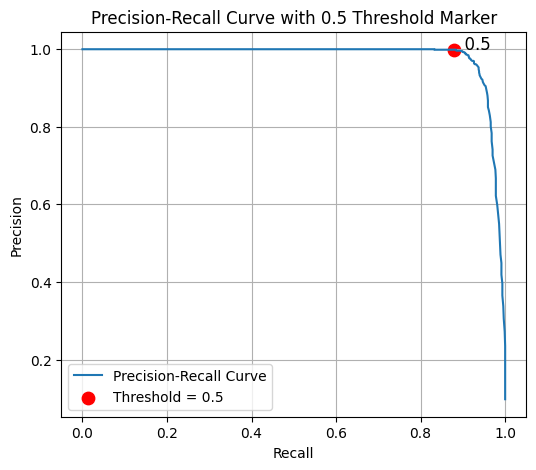

In [137]:
# Compute PR curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_prob)

# pr_thresholds has length N-1 relative to precision/recall arrays
idx_05_pr = np.argmin(np.abs(pr_thresholds - 0.5))

precision_05 = precision[idx_05_pr]
recall_05 = recall[idx_05_pr]

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.scatter(recall_05, precision_05, color="red", s=80, label="Threshold = 0.5")
plt.text(recall_05, precision_05, "  0.5", fontsize=12)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve with 0.5 Threshold Marker")
plt.legend()
plt.grid(True)
plt.show()

Best F1 Threshold: 0.3246
Best F1 Score: 0.9475


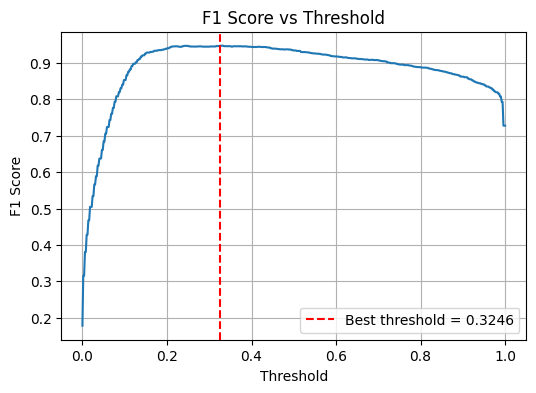

In [113]:
# --- Compute best F1 threshold ---
thresholds = np.linspace(0, 1, 500)
f1_scores = []

for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_t, zero_division=0))

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best F1 Threshold: {best_threshold:.4f}")
print(f"Best F1 Score: {best_f1:.4f}")

# --- Plot F1 vs Threshold curve ---
plt.figure(figsize=(6,4))
plt.plot(thresholds, f1_scores)
plt.axvline(best_threshold, color='red', linestyle='--', label=f"Best threshold = {best_threshold:.4f}")
plt.title("F1 Score vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.show()

<Figure size 500x400 with 0 Axes>

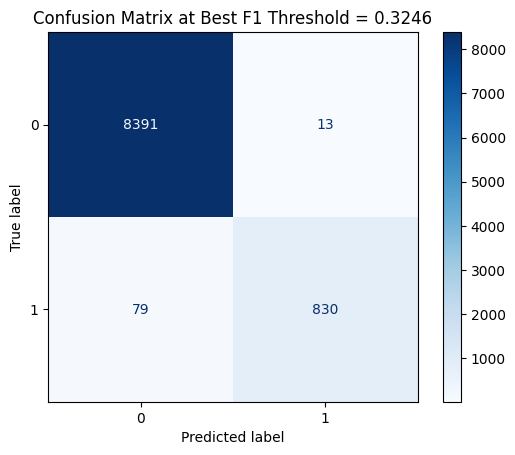

In [123]:
# --- Confusion matrix at best threshold ---
y_pred_best = (y_prob >= best_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(5,4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='d')
plt.title(f"Confusion Matrix at Best F1 Threshold = {best_threshold:.4f}")
plt.show()